# Assessment 2 
During the covid pandemic, governments tried to predict the levels of infection so that they could manage the required infrastructure, especially hospital beds and (sadly) mortuary places. In this mini-project, you will take data from two different, publicly available, sources and try to see how well you could have done if you had been working for the UK government.  One of the sources is the UK data from the period and the other is google’s data on our behaviour during the pandemic.

You will use data up to a specific date to predict hospital beds needed, and deaths that will occur  in one, two, three and four weeks from that date.  You will do this for the whole pandemic period i.e. using a rolling  window. You will also quantify how well your prediction works. Do a rolling window on predictions

Things that you might want to consider in your analysis include:

- There will be a time lag between people’s  behaviour changing and the number of people requiring a hospital bed (and another between people requiring hospitalisation and them dying).

- Both sources of data will have information that is  of no use to you and you will have to investigate those sources that are useful to you. You should start by thinking this through and then trying the effect of different variable.

- Both data sets may require some cleaning and (perhaps) some smoothing to remove effects such as weekends etc.

- As the situation changed some aspects of the older data nay or may not continue to be useful.  

- You may wish to do this by region or for the whole country, or even to compare the two.


We will provide you with basic code to access the data. It is up to you if you use it or not.
Use google data to predict,

nhs data goes further than google.

people were in hospital more near the end but not b/c they had covid but b/c of other reasons vaccines etc or other illness.

so only go up to period where we have data on deaths. make sure we go to the end of dates region (july 2021) but there might be another one for 2023

google data in until dec 2022 dont go beyond that

so its a regression problem, multi variable etc..

write code in a way we can easily change the engine we are using to predict, knn, gradient descent, dt, svm ....

long term short term training, fitted num of pos cases test (auto auto correlation ,minuit)

lets say there is an 8 day gap, so in pandas just shift the data from 8 days ago. gap between going to hospital and dying, gap between getting vaccine and when it becomes effective (2 weeks) could use LSTM. or just build time gap/shift into it. but not a good idea to use lstm very hard


## 1. Setup

In [64]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#Show plots inline
%matplotlib inline

#Some date formatters to use for plotting 
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

In [65]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

## 2. Predictors

In principle, covid cases, hospital admissions, and deaths are time-lagged outcomes of covariates or "predictor variables" such as the level of interactions in the population, mobility metrics, levels of restrictions etc.

A data set which is often used as a possible predictor is google mobility metrics https://www.google.com/covid19/mobility/.

In [66]:
#Import the data from Google.
#This is a large file!
df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

C:\Users\Mihir Koka\AppData\Local\Temp\ipykernel_16608\1332668652.py:3: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')


In [67]:
#Select `United Kingdom` from the full data.
df_google = df_google[df_google['country_region']=='United Kingdom']
#Discard sub regions
#Note - we England vs UK
df_google = df_google[df_google['sub_region_1'].isnull()]

In [68]:
#Re-index by data
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True, drop=True)
df_google.sort_index(inplace=True)
df_google.columns
df_google.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,,,,
2020-02-15,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0


Plot up some of the metrics. 

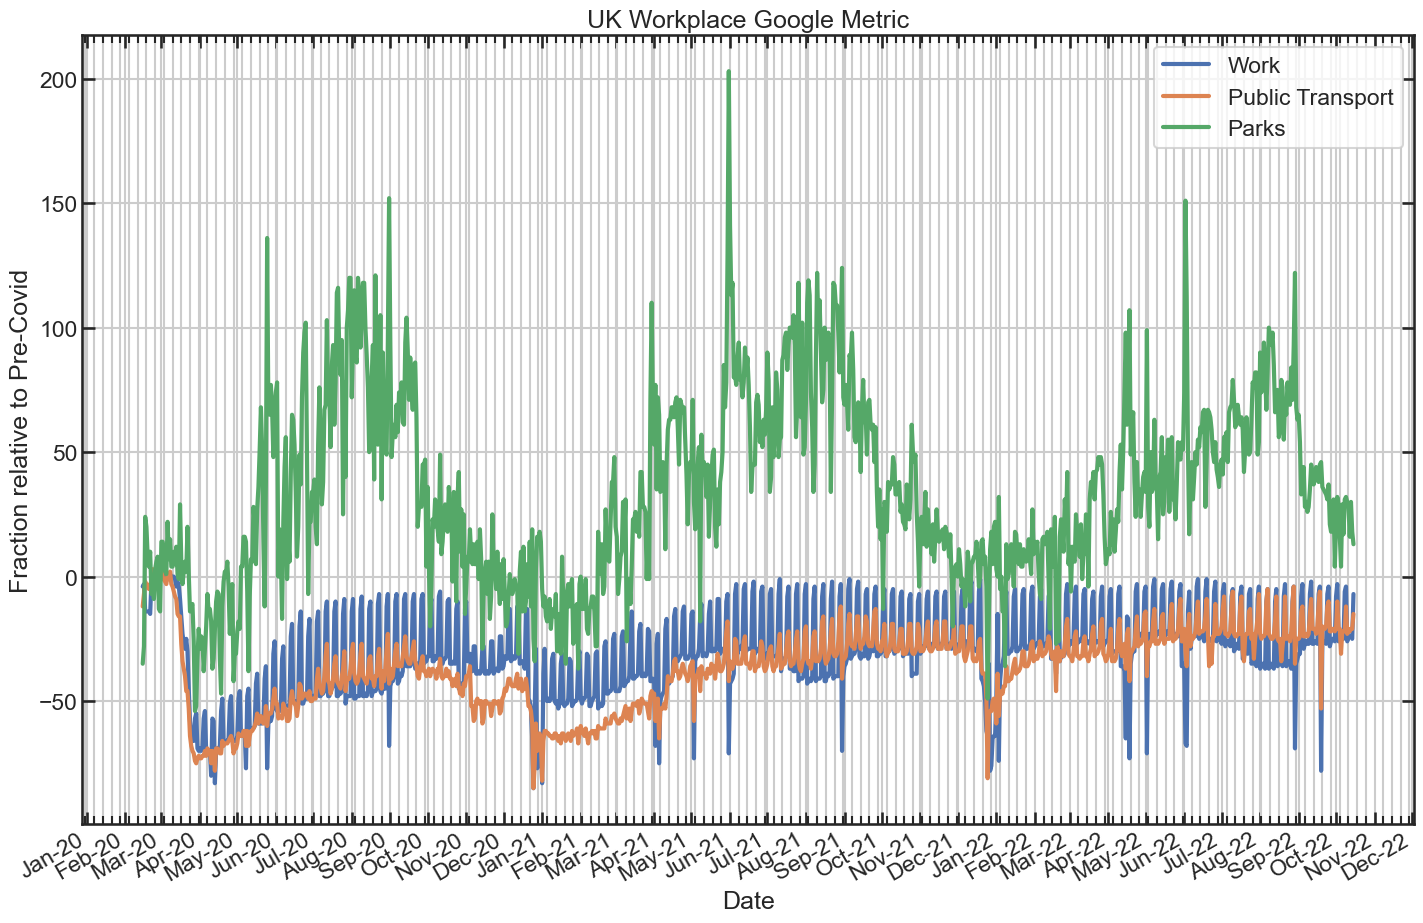

In [69]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')


ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

## The UK data from the covid period.

The UK data is available as a zip file from:

https://ukhsa-dashboard.data.gov.uk/covid-19-archive-data-download

this then needs to be unzipped 
```console
unzip  covid-19-archive.zip
```
This should produce a series of directories:
```console
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Cases
-rw-r--r--. 1 collngdj collngdj 1592889236 Oct 25 16:07 covid-19-archive.zip
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Deaths
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Healthcare
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Testing
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Vaccinations
```

each of these has a set of csv files arranged over different years.

The following code is an example of how you might want to read these in and concatinate them over different years.



In [70]:
import re
from enum import StrEnum, auto
import pathlib
import pandas as pd

class DataType(StrEnum):
    Cases = auto()
    Deaths = auto()
    Healthcare = auto()
    Testing = auto()
    Vaccinations = auto()


def csvconcat(datatype: DataType,
              metric: str | None = None,
              dataroot: str | pathlib.Path = pathlib.Path.cwd()) -> dict[str, pd.DataFrame]:
    """
    Get Pandas DataFrames from the UK COVID-19 .csv data, Concatenated across years.

    Args:
        datatype (DataType): Corresponds to the directory to scan use enum type above.
                             i.e. [DataType.Cases|DataType.Deaths|DataType.Healthcare|
                                   DataType.Testing|DataType.Vaccinations]
        metric (str | None, optional): Chose an individual metric to process. If None (the default) then all
                                       metrics for the given DataType are processed. Defaults to None.
        dataroot (pathlib.Path, optional): The root directory for the unpacked UK COVID-19 data.
                                           DataType directories (Cases/Deaths) etc should be under this root.
                                           Defaults to pathlib.Path.cwd().
    Raises:
        ValueError: If there is a failure to convert the given dataroot to a Path object.

    Returns:
        dict[str, pd.DataFrame]: The mapping from metric to fully concatenated DataFrame.
    """
    if not isinstance(dataroot, pathlib.Path):
        try:
            dataroot = pathlib.Path(dataroot)
        except:
            raise ValueError(f"dataroot: '{dataroot}' could not be converted to a Path.")

    dataroot /= datatype.name
    # metric_regex = re.compile(r"(?P<metric>\w+?)_(?P<specifier>nation|region|utla|ltla|overview)_20\d\d.csv")
    metric_regex = re.compile(r"(?P<specifier>nation|region|nhsRegion|nhsTrust|utla|ltla|msoa|overview)_(?P<metric>\w+?).csv")
    metrics: set[str] = {str(metric)}
    if metric is None:
        file_list = (file_.relative_to(dataroot).name for file_ in dataroot.rglob("*.csv"))
        metrics = {match.group("metric") for file_ in file_list if (match := metric_regex.match(file_))}

    ret = {}
    for current_metric in metrics:
        ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"*_{current_metric}.csv"))})
        # ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"{current_metric}_*.csv"))})

    return ret



In [71]:
# Get a specific metric
from pathlib import Path
# data = csvconcat(DataType.Healthcare, "hospitalCases")
data = csvconcat(DataType.Healthcare, "hospitalCases", dataroot=Path.cwd() / "UK data") # I changed mine to this b/c of the path to my data, you may need to change depending on where your data is.
print(data)

{'hospitalCases':             date area_type  area_code         area_name         metric  \
0     2020-03-01    nation  N92000002  Northern Ireland  hospitalCases   
1     2020-03-02    nation  N92000002  Northern Ireland  hospitalCases   
2     2020-03-03    nation  N92000002  Northern Ireland  hospitalCases   
3     2020-03-04    nation  N92000002  Northern Ireland  hospitalCases   
4     2020-03-05    nation  N92000002  Northern Ireland  hospitalCases   
...          ...       ...        ...               ...            ...   
3235  2020-12-27    region  E12000008        South East  hospitalCases   
3236  2020-12-27    region  E12000006   East of England  hospitalCases   
3237  2020-12-27    region  E12000001        North East  hospitalCases   
3238  2020-12-27    region  E12000005     West Midlands  hospitalCases   
3239  2020-12-27    region  E12000009        South West  hospitalCases   

               metric_name  value  
0     Patients in hospital   11.0  
1     Patients in hos

##### List metrics present by filename so i can easily choose what i want

In [72]:
# List metrics present by filename so i can easily choose what i want
from pathlib import Path
import re

def list_metrics_in_folder(folder: Path):
    rx = re.compile(r"^(?:nation|region|nhsRegion|nhsTrust|utla|ltla|msoa|overview)_(?P<metric>[\w]+?)(?:_20\d\d)?\.csv$")
    return sorted({m.group("metric") for f in folder.glob("*.csv") if (m := rx.match(f.name))})

healthcare_dir = Path.cwd() / "UK data" / "Healthcare"
all_directory_metrics = [Path.cwd() / "UK data" / "Cases", Path.cwd() / "UK data" / "Deaths", Path.cwd() / "UK data" / "Healthcare", Path.cwd() / "UK data" / "Testing", Path.cwd() / "UK data" / "Vaccinations"]
for path in all_directory_metrics:
    print(f"{path.name} metrics: {list_metrics_in_folder(path)}")

Cases metrics: ['changeInCumCasesBySpecimenDate', 'changeInNewCasesBySpecimenDate', 'cumCasesByPublishDate', 'cumCasesByPublishDateRate', 'cumCasesBySpecimenDate', 'cumCasesBySpecimenDateRate', 'cumCasesLFDConfirmedPCRBySpecimenDate', 'cumCasesLFDOnlyBySpecimenDate', 'cumCasesPCROnlyBySpecimenDate', 'cumCasesPillarOneBySpecimenDate', 'cumCasesPillarOneBySpecimenDateRate', 'cumCasesPillarTwoBySpecimenDate', 'cumFirstEpisodesBySpecimenDate', 'cumFirstEpisodesBySpecimenDateRate', 'cumReinfectionsBySpecimenDate', 'cumReinfectionsBySpecimenDateRate', 'femaleCases', 'hospitalCasesWeekly', 'maleCases', 'newCasesByPublishDate', 'newCasesByPublishDateChange', 'newCasesByPublishDateChangePercentage', 'newCasesByPublishDateDirection', 'newCasesByPublishDateRollingRate', 'newCasesByPublishDateRollingSum', 'newCasesBySpecimenDate', 'newCasesBySpecimenDateAgeDemographics', 'newCasesBySpecimenDateAgeDemographics_areas_letter_A', 'newCasesBySpecimenDateAgeDemographics_areas_letter_B', 'newCasesBySpeci

Realized after that this was already done here

In [73]:
# Get all metrics for a DataType
data = csvconcat(DataType.Healthcare, dataroot=Path.cwd() / "UK data")
print(f"Data contains {len(data)} concatenated metrics")
print(f"Checking our chosen metric 'transmissionRateGrowthRateMax' is found in data: {'transmissionRateGrowthRateMax' in data}")
print("Available metrics:")
print(list(data.keys()))

Data contains 50 concatenated metrics
Checking our chosen metric 'transmissionRateGrowthRateMax' is found in data: True
Available metrics:
['covidOccupiedMVBedsWeekly', 'cumDischarges', 'nonCovidOccupiedMVBeds', 'newAdmissionsWeekly_archive', 'cumAdmissions', 'cumCasesPillarTwoBySpecimenDateRate', 'newAdmissionsRollingRate', 'totalNIVBeds', 'transmissionRateGrowthRateMin', 'newAdmissions', 'cumDischargesRate', 'newAdmissionsChange', 'newAdmissionsWeekly', 'transmissionRateMin', 'newAdmissions_archive', 'alertLevel', 'totalMVBeds', 'transmissionRateMax', 'nonCovidOccupiedOSBeds', 'suspectedCovidOccupiedOSBeds', 'hospitalCasesWeekly_archive', 'nonCovidOccupiedOtherBeds', 'newAdmissionsDirection', 'unoccupiedOtherBeds', 'nonCovidOccupiedNIVBeds', 'transmissionRateGrowthRateMax', 'totalOSBeds', 'newDischarges', 'covidOccupiedMVBeds', 'newAdmissionsChangePercentage', 'totalOtherBeds', 'unoccupiedMVBeds', 'cumAdmissionsRate', 'unoccupiedOSBeds', 'hospitalCases_archive', 'suspectedCovidOccupi

 The first thing that you might want to play around with is trying to plot some of these data and comparing them to the different predictors.

## 3. A basic plan

So our goal here is to build a time-lagged, rolling forecasting model to predict future hospital bed needs and covid related deaths 1-4 weeks into the future using google mobility data and UK nhs data.

So let's go with a high level plan that we can loosely follow to guide us
- Selecting data: list all the data we have (like I did above for the csv's) and choose primary forecasting data.

- Data loading: Load mobility data(done), concatenate metrics onto standardized column names and a single data index and merge on this (if not already the case)

- Cleaning: make sure dates are in data.time format, maybe do a rolling mean on noisy data and see smooth vs raw
    - Flag out potential outliers that could affect our results

- Exploratory data Analysis (EDA): Maybe compute pearon cross-correlation on mobility vs targets to see what metrics have strong negative/positive relationships

- Engineer features
    - Lagged mobility features (7 dats - 1 month)
    - Rolling trends
    - etc..

- Make an abstract model: Allow us to plug in a different estimator into a function to let us try different things easily
    - Do an initial baseline: rolling means, simple linear regression
    - Then do ridge/lasso, decision trees, random forest, gradient descent/boosting, SVR, KNN .....

- Do a rolling walk forward:
     - Expanding window for training as we go
     - collect error metrics as we go to see how we are doing
     - compare models to baseline

- Model selection and interpretation of findings:

- Final reporting outline

#### Choosing data
So for predictors of deaths and hospital beds needed I'll be using "overview_newDeaths28DaysByDeathDate" and "overview_hospitalCases" respectively as my targets.

For deaths this is giving us the daily deaths within 28 days of a positive test, by the actual death date. We don't want to use cumalative data as it would be monotonically increasing so not very useful for predictions, we'd have to compute the difference anyway



Quickly checking start/end date of google data

In [74]:
last_date = df_google.index[-1]
start_date = df_google.index[0]
print(start_date, last_date)

2020-02-15 00:00:00 2022-10-15 00:00:00


For predictors along with google data I'm going to use:
- overview_newCasesBySpecimenDate
    - I prefer this over overview_newCasesByPublishDate because from what I've read specimen counts cases by when the test specimen was taken whereas publish counts from the date they were published. So the latter is better b/c it reflects when the infections were detected.
- New admissions flow
- vaccine cumulative counts 1st/2nd dose (might shift this for time lag)

In [75]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_ROOT = Path.cwd() / "UK data" # NOTICE_______________this the my folder name for the unzipped data. You may need to change this 
START_DATE = "2020-03-27" # when my hospital cases data starts
END_DATE   = "2022-05-19"   # Google data ends in 2022-10-15 but my deaths ends in 2022-05-19

# Target metrics
DEATHS_FILE = "overview_newDeaths28DaysByDeathDate"   # daily number of people who died within 28 days of a positive COVID‑19 test
HOSP_FILE   = "overview_hospitalCases"  # hospital cases

# simple predictors (keep lean for now, maybe add more later)
CASES_FILE  = "overview_newCasesBySpecimenDate"       # daily new cases by specimen date
ADM_FILE    = "overview_newAdmissions"                # daily admissions (flow)
VAX1_FILE   = "overview_cumPeopleVaccinatedFirstDoseByVaccinationDate"
VAX2_FILE   = "overview_cumPeopleVaccinatedSecondDoseByVaccinationDate"

MOBILITY_COLS = [ #the google mobility data, just creating the cols I might use for later.
    "retail_and_recreation_percent_change_from_baseline",
    "grocery_and_pharmacy_percent_change_from_baseline",
    "parks_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline"
]

# Horizons (days ahead 1-4 weeks)
HORIZONS = [7, 14, 21, 28]


# HELPERS to avoid repeating code ---
def load_overview(folder: str, stem: str) -> pd.DataFrame:
    """Load one overview_* csv and parse the date. Keep it simple."""
    df = pd.read_csv(DATA_ROOT / folder / f"{stem}.csv")
    df["date"] = pd.to_datetime(df["date"])
    return df.sort_values("date")

# load targets
df_deaths = load_overview("Deaths", DEATHS_FILE)
df_hosp   = load_overview("Healthcare", HOSP_FILE)

# load predictors (no fallbacks/checks)
df_cases = load_overview("Cases", CASES_FILE)
df_adm   = load_overview("Healthcare", ADM_FILE)
df_vax1  = load_overview("Vaccinations", VAX1_FILE)
df_vax2  = load_overview("Vaccinations", VAX2_FILE)

# google mobility already loaded earlier as df_google (UK-only, national)
# -----NOTICE NOTICE----. I had to import the df column in this ugly way b/c the daya had data as an index\
#  and col header, and I would keep getting value errors on ValueError: 'date' is both an index level and a column label, which is ambiguous. So I used AI to help me fix it as I was confused
if "date" in df_google.columns:
    df_google = df_google.drop(columns=["date"])
df_google.index = pd.to_datetime(df_google.index)
df_google.index.name = None  # prevent 'date' being both index level and column

mobility = df_google[MOBILITY_COLS].copy()
mobility["date"] = mobility.index  # add date as a column for merge
mobility.index.name = None


def pick_value_cols(df: pd.DataFrame, new_name: str) -> pd.DataFrame:
    """CSV columns: date, area_type, area_code, area_name, metric, metric_name, value.
       We only keep date + value and rename value."""
    return df[["date", "value"]].rename(columns={"value": new_name})

# tidy to 2 columns (date, value) per series; drop area fields (we're UK-wide)
df_deaths = pick_value_cols(df_deaths, "deaths")
df_hosp   = pick_value_cols(df_hosp,   "hospitalCases")
df_cases  = pick_value_cols(df_cases,  "newCases")
df_adm    = pick_value_cols(df_adm,    "newAdmissions")
df_vax1   = pick_value_cols(df_vax1,   "cumFirstDose")
df_vax2   = pick_value_cols(df_vax2,   "cumSecondDose")

# merge everything on date (inner join keeps common dates)
merged = df_deaths.merge(df_hosp, on="date", how="inner") \
                  .merge(df_cases, on="date", how="inner") \
                  .merge(df_adm,   on="date", how="inner") \
                  .merge(df_vax1,  on="date", how="inner") \
                  .merge(df_vax2,  on="date", how="inner") \
                  .merge(mobility, on="date", how="inner")

# restrict modeling window
merged = merged.set_index("date").loc[START_DATE:END_DATE].copy()

# some smoothing for noisy parts, so we can add a moving average col 
def add_ma(df: pd.DataFrame, cols: list[str], window: int = 7) -> pd.DataFrame:
    """Add a 7Day rolling mean for quick EDA."""
    for c in cols:
        if c in df.columns:
            df[f"{c}_ma{window}"] = df[c].rolling(window).mean()
    return df

merged = add_ma(merged, ["deaths", "newCases", "newAdmissions"], window=7)

# lag features for targets, like for vaccines etc..
def add_lags(df: pd.DataFrame, col: str, lags: list[int]) -> pd.DataFrame:
    """Create past-value features like col_lag_7."""
    for l in lags:
        df[f"{col}_lag_{l}"] = df[col].shift(l)
    return df

merged = add_lags(merged, "deaths", [1, 2, 3, 7, 14])
merged = add_lags(merged, "hospitalCases", [1, 2, 3, 7, 14])

print("Merged shape:", merged.shape)
print("Columns snapshot:", merged.columns[:20].tolist())

# quick correlations simple EDA
def quick_corr(df: pd.DataFrame, target: str, features: list[str]) -> pd.DataFrame:
    """Plain Pearson; just to see what's roughly related."""
    valid = df.dropna(subset=[target] + features) # only want rows where target and features are present
    out = {f: valid[target].corr(valid[f]) for f in features} # Compute the pearson corr between target and each feature
    return pd.DataFrame.from_dict(out, orient="index", columns=["pearson"]).sort_values("pearson", ascending=False)

feat_deaths = [c for c in (["newCases","newAdmissions","hospitalCases",
                            "cumFirstDose","cumSecondDose"] + MOBILITY_COLS)
               if c in merged.columns]

print("\nSame-day Pearson vs deaths (top 10):")
print(quick_corr(merged, "deaths", feat_deaths).head(10))

# example: cases leading deaths by 7 & 14 days
for lag in [7, 14]:
    tmp = merged[["deaths","newCases"]].copy()
    tmp["newCases_lag"] = tmp["newCases"].shift(lag)
    tmp = tmp.dropna()
    print(f"Pearson(deaths, newCases shifted {lag}d) = {tmp['deaths'].corr(tmp['newCases_lag']):.3f}")

Merged shape: (502, 25)
Columns snapshot: ['deaths', 'hospitalCases', 'newCases', 'newAdmissions', 'cumFirstDose', 'cumSecondDose', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'deaths_ma7', 'newCases_ma7', 'newAdmissions_ma7', 'deaths_lag_1', 'deaths_lag_2', 'deaths_lag_3', 'deaths_lag_7', 'deaths_lag_14']

Same-day Pearson vs deaths (top 10):
                                                     pearson
hospitalCases                                       0.934465
newAdmissions                                       0.849989
residential_percent_change_from_baseline            0.510993
newCases                                            0.097640
workplaces_percent_change_from_baseline            -0.298753
cumSecondDose                                      

##### So what did we find from this simple pearson correlation against deaths and the lagged deaths shifted by 1-2 weeks

- Very strong same-day correlation with hospitalCases (0.93) and newAdmissions (0.85). Makes sense as both show a similar metric

- Mobility has moderate correlations: residential is positive (0.51), others are negative (-0.30 to -0.63).
   - Interpretation: when deaths are high, people stay home more and visit workplaces/retail/transit less (behavioral/policy response), not necessarily causal for same day.
   
- Vaccination (cumSecondDose) is moderately negative (-0.39): higher coverage makes sense with lower deaths over time.

- New sases same-day is weak (0.10), but improves when cases are shifted forward: 0.18 at 7 days, ~0.27 at 14 days. That supports my idea to use cases as a indicator with a lag (1–3 weeks) for deaths.

##### Engineering features as per the plan (mobility, lag, rolling window..)

- making_xy builds a dataset for a horizon h by pairing a feature at a given time t with a target at t+h (for future)
- then walk forward makes a expanding/rolling window test, for each time i we rain on all the rows upto that time i and then predict row i's t+h target.
- make baselines a simple 7-day moving average.

trying ridge, lasso, random forest, knn etc... and comparing on small sets

Note we shift the future rows to make sure we can align the features are the same t e.g some target at t+h, so shifting indexes the future targets on the current feature timestamps.

In [ ]:
#  Walk-forward forecasting 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Feature engineering: add predictor lags
def add_lags_multi(df: pd.DataFrame, cols: list[str], lags: list[int]) -> pd.DataFrame:
    """Add lag columns for each col and k in lags."""
    for col in cols:
        if col not in df.columns:
            continue
        for k in lags:
            df[f"{col}_lag_{k}"] = df[col].shift(k)
    return df

# choose predictors to lag (exclude target 'deaths' for now b/c we already lagged deaths & hospitalCases in the previous code block)
PRED_LAG_COLS = ["newCases", "newAdmissions"] + MOBILITY_COLS
merged = add_lags_multi(merged, PRED_LAG_COLS, lags=[7,14,21])

# Drop initial rows with NaNs, can cause issues when doing computations on them
model_df = merged.dropna().copy()

def make_xy(df: pd.DataFrame, target: str, horizon: int, feature_cols: list[str]):
    """
    Construct pairs for a given horizon:
    y_t_plus_h = target shifted -h; features at time t.
    """
    y = df[target].shift(-horizon)
    X = df[feature_cols]
    data = pd.concat([X, y.rename(f"{target}_future_{horizon}")], axis=1).dropna()
    return data[feature_cols], data[f"{target}_future_{horizon}"]

def walk_forward(df: pd.DataFrame,
                 target: str,
                 horizon: int,
                 feature_cols: list[str],
                 model,
                 min_train: int = 120):
    """
    Expanding window walk-forward:
    For each time index i >= min_train, train on rows [0:i), predict row i's horizon target.
    so we train upto but not including i, and predict for i
    """
    preds = []
    actuals = []
    dates = []
    scaler = StandardScaler()

    # Pre-build supervised dataset
    X_all, y_all = make_xy(df, target, horizon, feature_cols)

    for i in range(min_train, len(X_all)):
        train_idx = X_all.index[:i]      # up to but not including i
        test_idx  = X_all.index[i]       # predict for this date (the feature date)
        # Train set
        X_train = X_all.loc[train_idx]
        y_train = y_all.loc[train_idx]
        # Test row features
        X_test = X_all.loc[[test_idx]]

        # Fit 
        if isinstance(model, (Ridge, KNeighborsRegressor, SGDRegressor)):
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled  = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)[0]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)[0]

        # Actual future value at test_idx
        y_true = y_all.loc[test_idx]

        preds.append(y_pred)
        actuals.append(y_true)
        dates.append(test_idx)

    res = pd.DataFrame({"date": dates, "y_true": actuals, "y_pred": preds}).set_index("date")
    mae  = mean_absolute_error(res.y_true, res.y_pred)
    rmse = root_mean_squared_error(res.y_true, res.y_pred)
    mape = (np.abs((res.y_true - res.y_pred) / res.y_true.replace(0, np.nan))).mean()
    return res, {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# -------- Baselines --------

#assume future value is same as current value
def baseline_naive(df: pd.DataFrame, target: str, horizon: int):
    """
    y_hat(t+h) = y(t). Evaluate over aligned rows.
    """
    y_future = df[target].shift(-horizon)
    y_pred   = df[target]
    data = pd.DataFrame({"y_true": y_future, "y_pred": y_pred}).dropna()
    mae  = mean_absolute_error(data.y_true, data.y_pred)
    rmse = root_mean_squared_error(data.y_true, data.y_pred)
    mape = (np.abs((data.y_true - data.y_pred) / data.y_true.replace(0, np.nan))).mean()
    return data, {"MAE": mae, "RMSE": rmse, "MAPE": mape}

#7 day mean upto time t
def baseline_ma7(df: pd.DataFrame, target: str, horizon: int):
    """
    y_hat(t+h) = 7-day moving average up to t.
    """
    ma = df[target].rolling(7).mean()
    y_future = df[target].shift(-horizon)
    data = pd.DataFrame({"y_true": y_future, "y_pred": ma}).dropna()
    mae  = mean_absolute_error(data.y_true, data.y_pred)
    rmse = root_mean_squared_error(data.y_true, data.y_pred)
    mape = (np.abs((data.y_true - data.y_pred) / data.y_true.replace(0, np.nan))).mean()
    return data, {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# Select feature set
# Keeping a few for now (current value + key lags + mobility lags)
FEATURES_BASE = [
    "newCases", "newAdmissions", "hospitalCases",
    "newCases_lag_7", "newCases_lag_14", "newCases_lag_21",
    "newAdmissions_lag_7", "newAdmissions_lag_14",
    "hospitalCases_lag_7", "hospitalCases_lag_14",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "retail_and_recreation_percent_change_from_baseline"
]

# Filter for above features
FEATURES = [f for f in FEATURES_BASE if f in model_df.columns]



##### NOTE
I'm just defining the functions above for now. Below I will now use them to get our errors and plots for beds and deaths

##### Resuable function to eval deaths and beds

So I then made this function evaluate_and_plot() to do both the error comparison output + plotting. We have some repeated output from above here from the deaths data, so I'll just be talking about the hospital beds results

In [ ]:
#  Reusable evaluation + plotting for any target (deaths, hospitalCases etc.) -----
def evaluate_and_plot(target: str, horizons: list[int], features: list[str], min_train: int = 120):
    """
    Generic walk-forward evaluation + plots.
    Returns summary DataFrame and dict[horizon][model] = (results_df, stats).
    """
    summary_rows = []
    all_results = {}

    for h in horizons:
        # Baselines
        _, stats_naive = baseline_naive(model_df, target, h)
        _, stats_ma7   = baseline_ma7(model_df, target, h)

        # Models
        ridge_res, ridge_stats = walk_forward(model_df, target, h, features, Ridge(alpha=2.0), min_train)
        rf_res,    rf_stats    = walk_forward(model_df, target, h, features, RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1), min_train)
        knn_res,   knn_stats   = walk_forward(model_df, target,h, features, KNeighborsRegressor(n_neighbors=8, weights="distance"), min_train)
        sgd_res,   sgd_stats   = walk_forward(model_df, target, h, features, SGDRegressor(loss="squared_error", penalty="l2", alpha=1e-4, max_iter=2000, tol=1e-4, random_state=42), min_train)

        summary_rows.append({
            "target": target,
            "horizon": h,
            "naive_MAE": stats_naive["MAE"],
            "ma7_MAE": stats_ma7["MAE"],
            "ridge_MAE": ridge_stats["MAE"],
            "rf_MAE": rf_stats["MAE"],
            "knn_MAE": knn_stats["MAE"],
            "ridge_RMSE": ridge_stats["RMSE"],
            "rf_RMSE": rf_stats["RMSE"],
            "knn_RMSE": knn_stats["RMSE"],
            "sgd_MAE": sgd_stats["MAE"],
            "sgd_RMSE": sgd_stats["RMSE"]
        })

        all_results[h] = {
            "ridge": (ridge_res, ridge_stats),
            "rf":    (rf_res, rf_stats),
            "knn":   (knn_res, knn_stats),
            "sgd":   (sgd_res, sgd_stats),
            "naive": stats_naive,
            "ma7":   stats_ma7
        }

    summary = pd.DataFrame(summary_rows)

    # Plot actual vs predictions (rf + ridge + knn) per horizon
    fig, axes = plt.subplots(len(horizons), 1, figsize=(15, 3.2*len(horizons)), sharex=True, facecolor="white")
    if len(horizons) == 1:
        axes = [axes]
    for ax, h in zip(axes, horizons):
        rf_res, rf_stats = all_results[h]["rf"]
        ax.plot(rf_res.index, rf_res.y_true, color="black", label="Actual")
        for name in ["rf", "ridge", "knn", "sgd"]:
            res, stats = all_results[h][name]
            ax.plot(res.index, res.y_pred, label=f"{name} (MAE={stats['MAE']:.1f})")
        ax.set_title(f"{target} forecast h={h}d")
    axes[0].legend()
    plt.tight_layout()

    return summary, all_results

#----------- Doing the same thing as before but for both deaths and beds with one reusable function -----
from IPython.display import display

# Deaths: summary + plots
summary_deaths, results_deaths = evaluate_and_plot("deaths", HORIZONS, FEATURES, min_train=120)
display(summary_deaths)

# Hospital beds: reuse the same feature set (it already includes hospitalCases lags)
FEATURES_HOSP = [f for f in FEATURES if f in model_df.columns]
summary_hosp, results_hosp = evaluate_and_plot("hospitalCases", HORIZONS, FEATURES_HOSP, min_train=120)
display(summary_hosp)

So I had to make changes to the above code, and calculating that takes about ~7min. To avoid having to do it again I just kept the variables and made a function just to plot the graph output. But in your case if you're running it just doing the above cell should suffice

,target,horizon,naive_MAE,ma7_MAE,ridge_MAE,rf_MAE,knn_MAE,ridge_RMSE,rf_RMSE,knn_RMSE,sgd_MAE,sgd_RMSE
0,deaths,7,32.915612,40.306471,31.643366,14.398923,18.322666,43.603653,18.754143,24.009671,35.939918,48.011571
1,deaths,14,55.888651,60.942051,27.385978,15.558762,19.565242,38.109228,20.426717,25.451683,29.364894,40.347566
2,deaths,21,75.410870,77.395846,31.698780,16.941154,21.101655,43.850234,23.246797,27.672206,32.182030,43.995201
3,deaths,28,89.885210,88.428571,37.672341,19.224738,22.611977,50.897448,27.087267,30.853844,37.650543,50.511961


,target,horizon,naive_MAE,ma7_MAE,ridge_MAE,rf_MAE,knn_MAE,ridge_RMSE,rf_RMSE,knn_RMSE,sgd_MAE,sgd_RMSE
0,hospitalCases,7,1355.202532,1847.380037,462.095015,454.225997,920.345306,664.162462,627.920374,1316.274463,535.033946,755.454460
1,hospitalCases,14,2552.601713,2927.271460,1017.328177,657.943297,996.593927,1549.470580,967.498970,1482.392667,1048.382684,1597.837123
2,hospitalCases,21,3545.910870,3796.075519,1748.744194,808.630282,1131.221725,2636.417839,1309.446295,1792.614601,1756.937387,2674.005554
3,hospitalCases,28,4321.443709,4447.965165,2355.205582,1071.074186,1280.493983,3486.968359,1929.893107,2115.681769,2377.464585,3511.977060


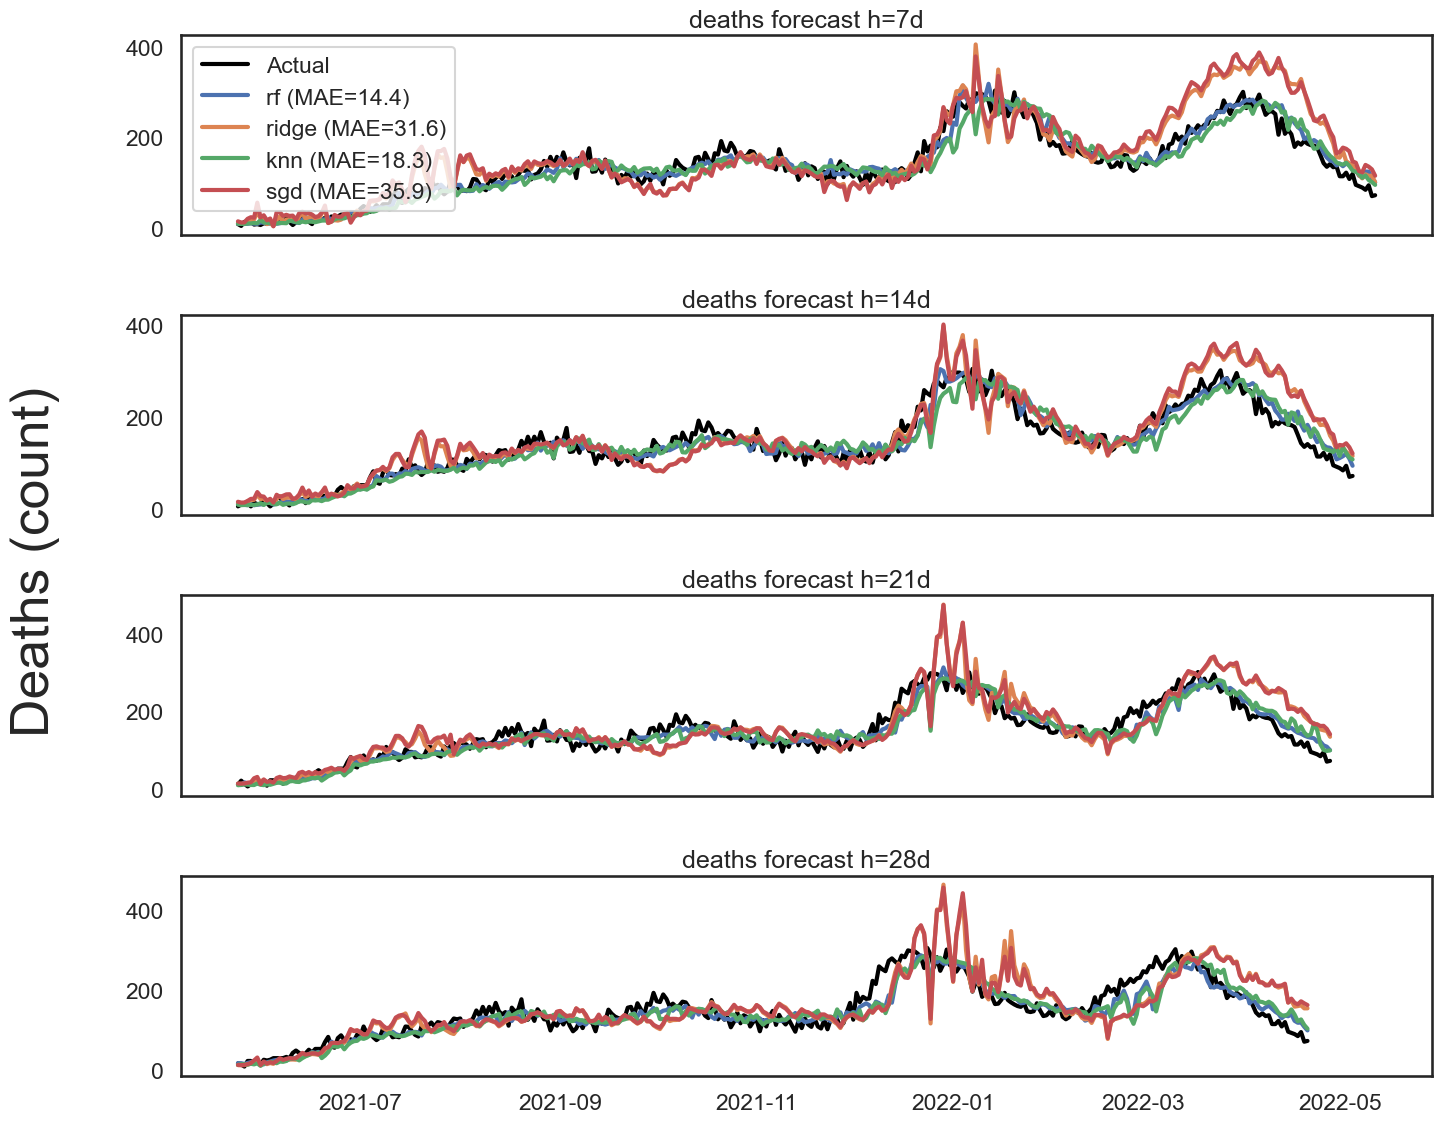

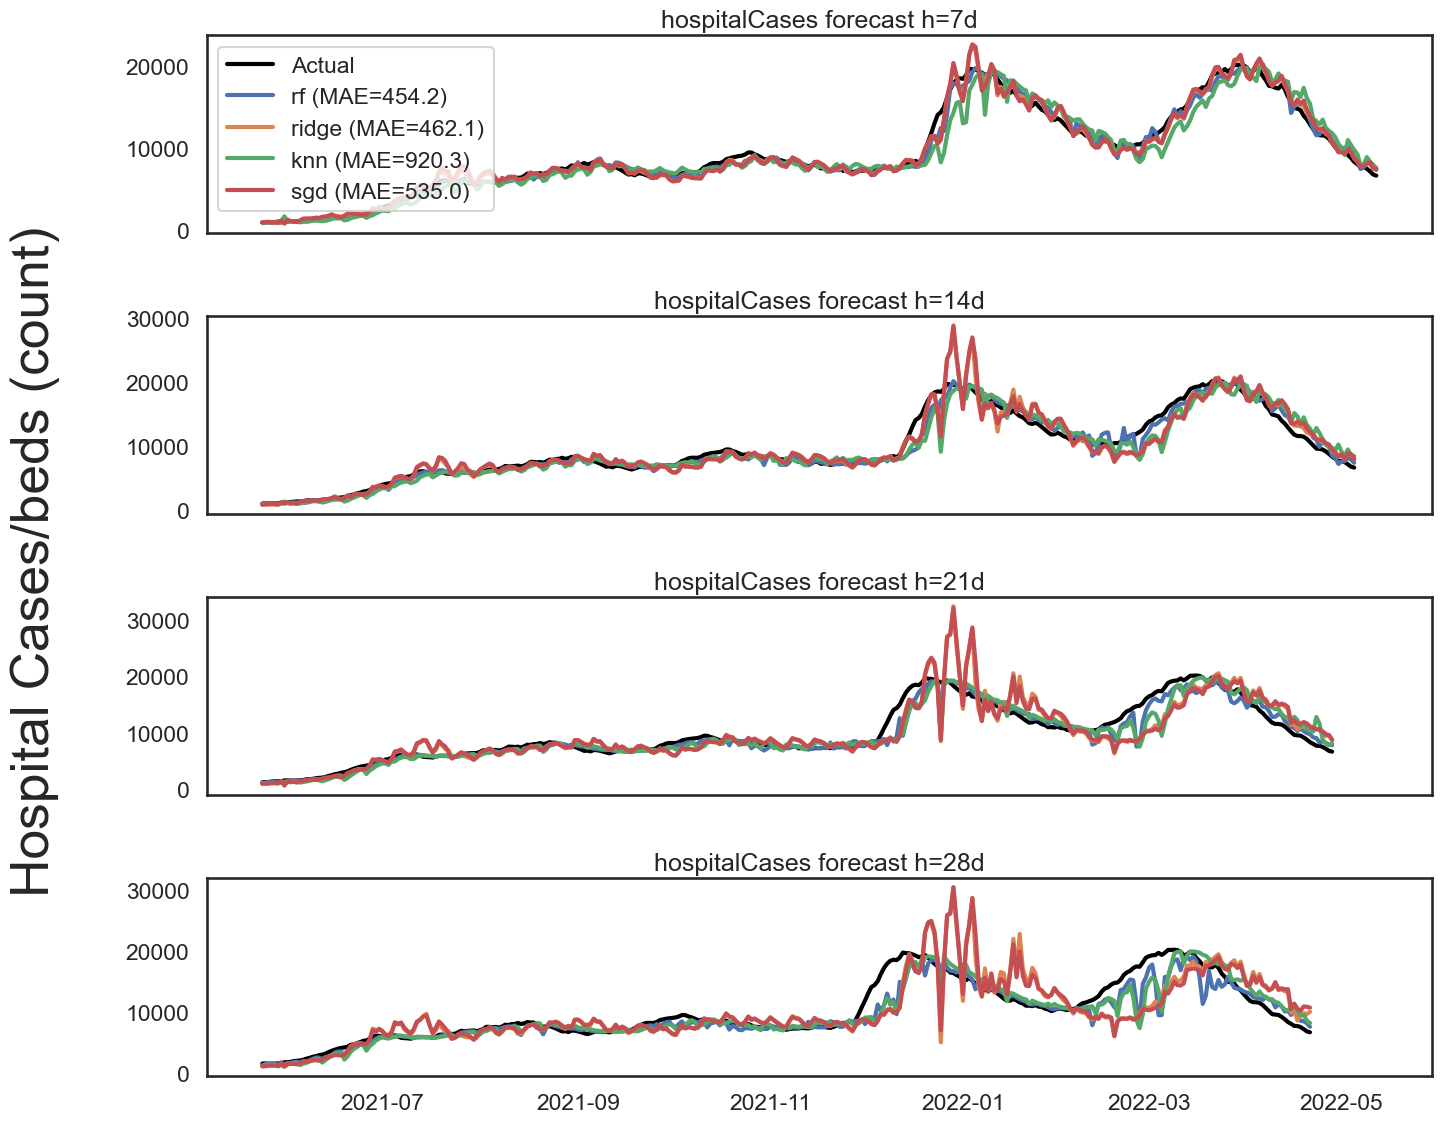

In [80]:
def plot_from_results(all_results: dict, title_prefix: str, horizons: list[int] | None = None):
    """Redraw plots from cached results dict returned by evaluate_and_plot."""
    import numpy as np
    if horizons is None:
        horizons = list(all_results.keys())
    fig, axes = plt.subplots(len(horizons), 1, figsize=(15, 3*len(horizons)),
                             sharex=True, facecolor="white")
    if len(horizons) == 1:
        axes = [axes]
    for ax, h in zip(axes, horizons):
        # use RF to get y_true/index (could be any of rf/ridge/knn)
        rf_res, rf_stats = all_results[h]["rf"]
        ax.plot(rf_res.index, rf_res.y_true, color="black", label="Actual")
        for name in ["rf", "ridge", "knn", "sgd"]:
            res, stats = all_results[h][name]
            ax.plot(res.index, res.y_pred, label=f"{name} (MAE={stats['MAE']:.1f})")
            if title_prefix == "hospitalCases":
                fig.supylabel("Hospital Cases/beds (count)") #keeps just one label instead of 4 making them squished.
            else:
                fig.supylabel("Deaths (count)")
        ax.set_title(f"{title_prefix} forecast h={h}d")
    axes[0].legend()
    plt.tight_layout()

plot_from_results(results_deaths, "deaths", HORIZONS)
plot_from_results(results_hosp, "hospitalCases", HORIZONS)
display(summary_deaths); display(summary_hosp)

##### What this shows us about deaths ?
We're seeing the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) of daily deaths with units in people/day for horizons of 1-4 weeks. Lower values mean better results.

 - RandomForest (rf) has the lowest error at all time horizons, large improvements especially at longer horizons where the naive approach drifts away from true

 - Ridge improves the naive approach but is worse than RF, could still be useful as a linear benchmark though

 - KNN similarly is better than naive but worse than RF
 
 - Stochastic gradient descent (SGD) seems to not be able to capture the relationships/lag interactions we have (that are important), but RF does. SGD doesn't really offer anything over Ridge and by 4 weeks they converge anyway.

 - The moving average baseline (ma7) is worse than naive for short horizons, I suspect this is b/c the smoothing and lagging we do makes the small shifts harder to track for it on a short window

 In general the performance gets worse as the horizon increases.

------------------------------------------------------------------
##### What this shows us about cases/beds ?

We're seeing the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) in predicted hospital beds h days in advance in units of beds/day. So lower is better once again.

- Once again errors increase with horizon time for all the models, makes sense as predicting gets harder the further into the future we go

##### Model comparison
- Random forest:
    - is again seemingly the best at all the horizons, the MAE grows fairly slowly
    - against the baseline its about 66% lower at 1 week (454 vs 1355) and ~75% lower at 4 weeks
- Ridge:
    - Pretty close to RF at a week but gets worse as the horizon increases
- KNN:
    - Worse than ridge at a week but better at longer horizons (2-4 weeks)

- SGD:
    - Again SGD is similar to Ridge but worse, and quite a bit worse than KNN at 3-4 weeks.

- Baselines: 
    - Naive is the worse and gets bad quickly as time goes on

- Main takeaway:
    - RF captures the relationships and lag the best, as seen with it keeping the smallest error growth with time
    - Ridge is pretty solid in short horizons linear benchmarks but gets worse over longer time periods
    - KNN seems to outperform ridge after ~2 weeks but still falls behind RF.


##### Quick recap of stuff so far
- Loaded the NHS (target + predictor) and Google mobility behavior
- Merged the data into one DF and added cols for smoothing and time lag
- Did a expanding forward walk for time for 1-4 weeks
    - basically whats being done here is this: for each row(date) we added a col for the data from the next 1-4 weeks. We then make a prediction on that and aggregate the error of that prediction over the whole period giving us the final error values we saw in the table and plot



##### Doing a prediction for the last X weeks of the data

,target,model,horizon,n_train,n_test,MAE,RMSE,MAPE_pct,R2
0,deaths,knn,7,433,41,21.968382,28.067662,17.084361,0.819770
1,deaths,rf,7,433,41,33.278235,40.105817,23.152965,0.632016
2,deaths,ridge,7,433,41,102.583482,109.577772,62.483083,-1.747004
3,deaths,sgd,7,433,41,105.427865,111.984786,64.468594,-1.869012
4,deaths,knn,14,433,34,39.415785,44.227913,31.652315,0.341979
5,deaths,rf,14,433,34,44.678584,49.700713,32.011143,0.169055
6,deaths,ridge,14,433,34,99.300712,102.526605,69.896024,-2.536064
7,deaths,sgd,14,433,34,102.096025,105.445113,72.099325,-2.740243
8,deaths,rf,21,433,27,47.174686,50.492567,40.739918,-0.516910
9,deaths,knn,21,433,27,62.342639,70.579456,58.210170,-1.963886


,target,model,horizon,n_train,n_test,MAE,RMSE,MAPE_pct,R2
0,hospitalCases,ridge,7,433,41,712.973203,797.871312,6.060591,0.963782
1,hospitalCases,sgd,7,433,41,786.627238,887.094437,6.598573,0.955228
2,hospitalCases,rf,7,433,41,831.298664,1096.993178,6.621569,0.931534
3,hospitalCases,knn,7,433,41,878.934255,1336.697165,6.707846,0.898345
4,hospitalCases,rf,14,433,34,1601.600015,1897.887180,14.300352,0.706796
5,hospitalCases,ridge,14,433,34,1768.843251,1861.480278,16.651365,0.717937
6,hospitalCases,sgd,14,433,34,1941.183911,2056.981205,18.282281,0.655578
7,hospitalCases,knn,14,433,34,2110.212605,2434.085471,21.322040,0.517718
8,hospitalCases,rf,21,433,27,2225.015601,2414.165200,24.012033,0.093195
9,hospitalCases,ridge,21,433,27,3156.117262,3259.616454,32.266749,-0.653153


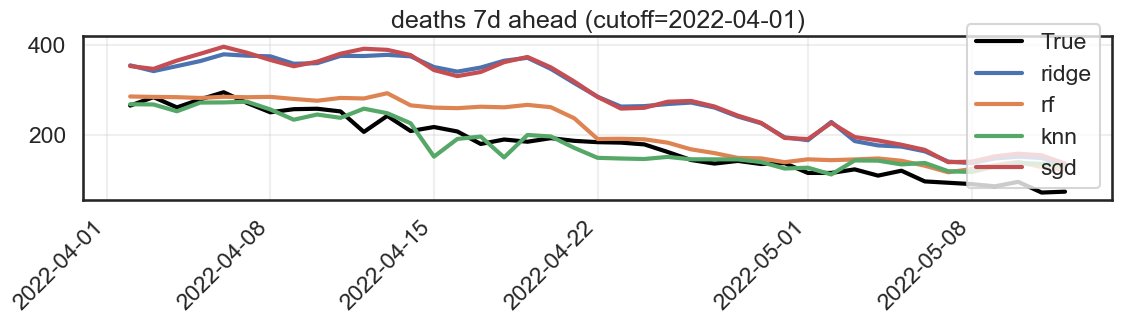

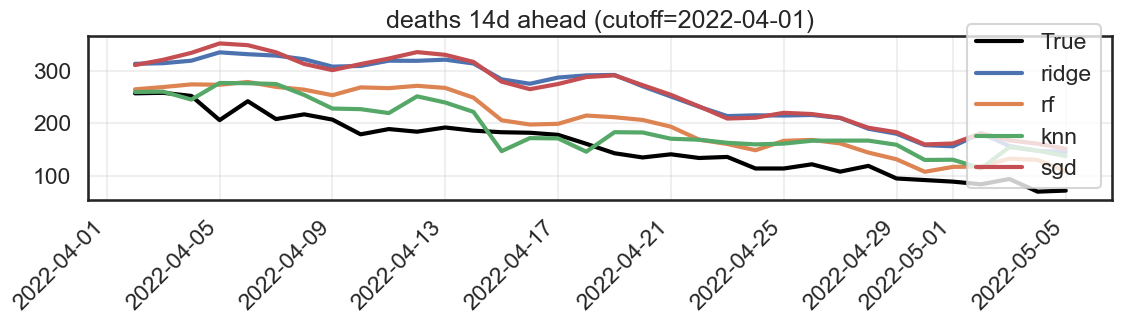

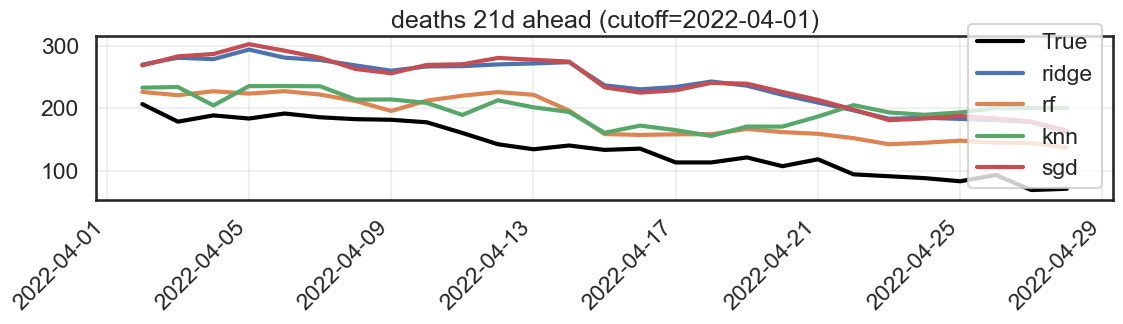

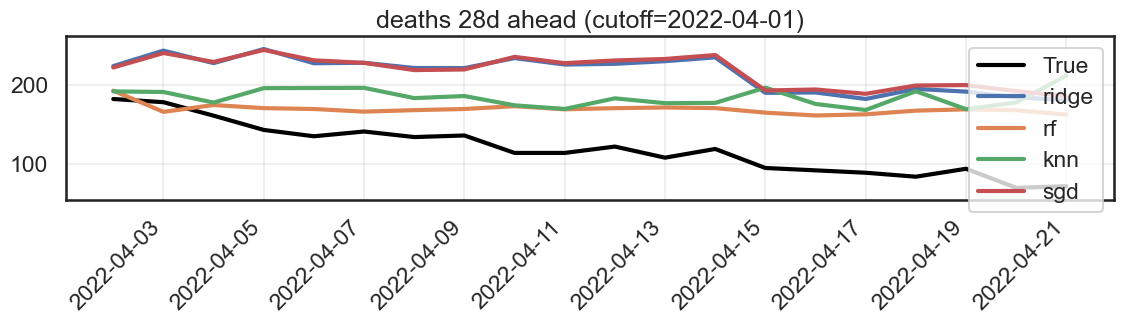

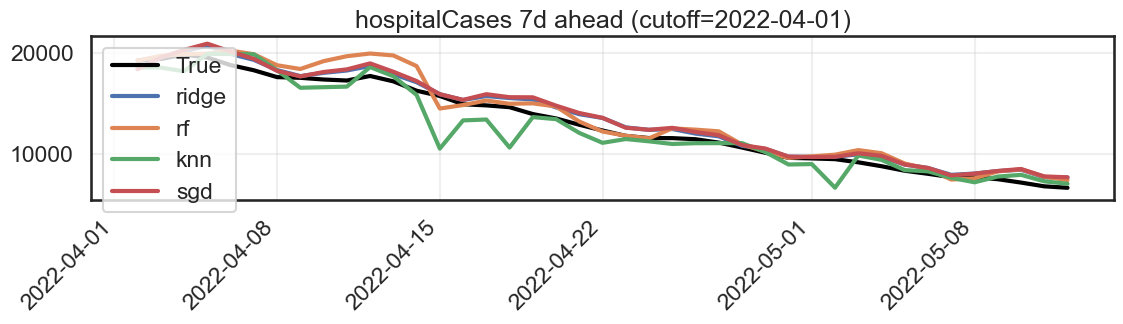

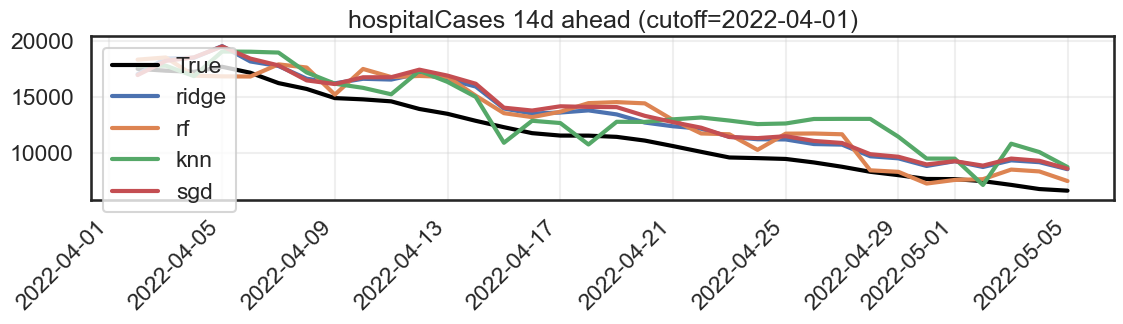

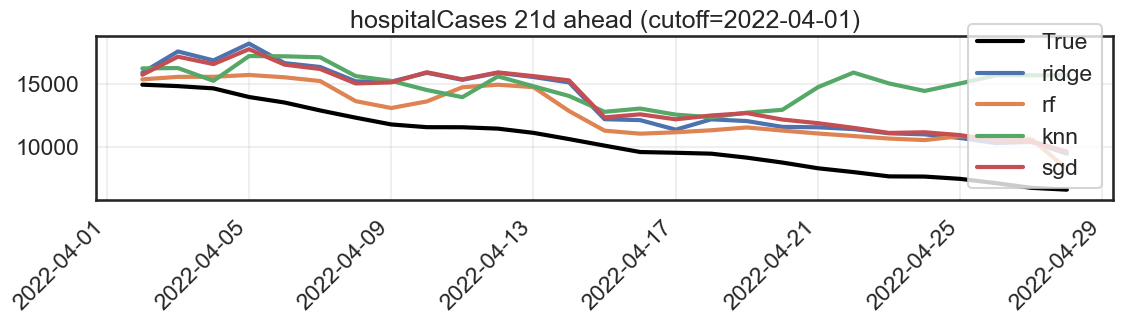

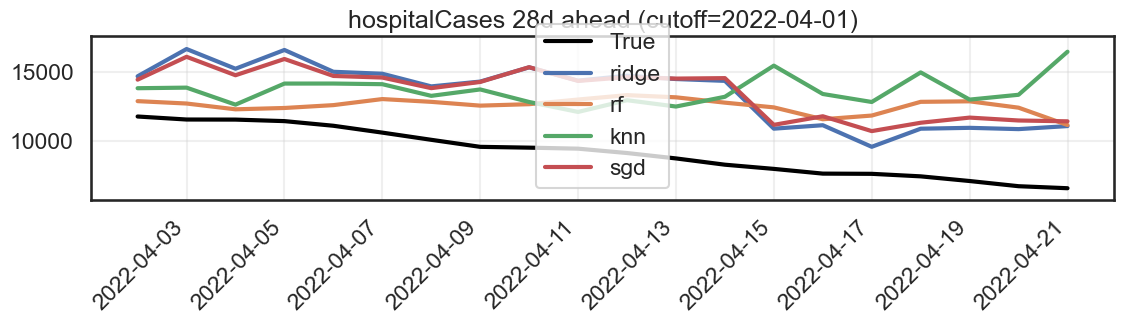

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

SIMPLE_MODELS = {
    "ridge": Ridge(alpha=2.0),
    "rf": RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1),
    "knn": KNeighborsRegressor(n_neighbors=8, weights="distance"),
    "sgd": SGDRegressor(loss="squared_error", penalty="l2", alpha=1e-4, max_iter=2000, tol=1e-4, random_state=42),
}

def simple_final_holdout(df: pd.DataFrame,
                         target: str,
                         features: list[str],
                         cutoff: str | pd.Timestamp,
                         horizon: int):
    """Train each model up to cutoff and evaluate on future rows > cutoff."""
    cutoff = pd.to_datetime(cutoff)

    #making the pairs
    y_future = df[target].shift(-horizon)
    data = pd.concat([df[features], y_future.rename("y_future")], axis=1).dropna()
    train_mask = data.index <= cutoff
    test_mask  = data.index > cutoff
    if not test_mask.any(): #incase we try to set past what we have in the data
        raise ValueError("No test rows after cutoff. Pick earlier cutoff or reduce horizon.")
    X_train, y_train = data.loc[train_mask, features], data.loc[train_mask, "y_future"]
    X_test,  y_test  = data.loc[test_mask,  features], data.loc[test_mask,  "y_future"]

    rows = []
    preds_per_model = {}
    for name, model in SIMPLE_MODELS.items():
        # scale ridge/knn/sgd; not rf
        if isinstance(model, (Ridge, KNeighborsRegressor, SGDRegressor)):
            scaler = StandardScaler().fit(X_train)
            Xtr, Xte = scaler.transform(X_train), scaler.transform(X_test)
        else:
            Xtr, Xte = X_train, X_test

        model.fit(Xtr, y_train)
        y_pred = pd.Series(model.predict(Xte), index=X_test.index)
        preds_per_model[name] = y_pred

        # show MAPE as percent (avoid div by zero by epsilon)
        eps = np.finfo(float).eps
        mape_pct = 100.0 * mean_absolute_percentage_error(y_test.clip(lower=eps), y_pred)

        rows.append({
            "model": name,
            "horizon": horizon,
            "n_train": len(X_train),
            "n_test": len(X_test),
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": root_mean_squared_error(y_test, y_pred),
            "MAPE_pct": mape_pct,
            "R2": r2_score(y_test, y_pred),
        })
    metrics_df = pd.DataFrame(rows).sort_values("MAE")
    return metrics_df, y_test, preds_per_model

def plot_final_predictions(y_true: pd.Series,
                           preds_per_model: dict[str, pd.Series],
                           target: str,
                           horizon: int,
                           cutoff: str):
    plt.figure(figsize=(12,4))
    plt.plot(y_true.index, y_true, color="black", label="True")
    for name, series in preds_per_model.items():
        plt.plot(series.index, series, label=name)

    # robust y-limits to avoid a single bad model flattening the view
    vals = np.concatenate([y_true.values] + [s.values for s in preds_per_model.values()])
    q1, q99 = np.quantile(vals, [0.01, 0.99])
    rng = max(q99 - q1, 1e-6)
    plt.ylim(q1 - 0.1*rng, q99 + 0.1*rng)

    plt.title(f"{target} {horizon}d ahead (cutoff={cutoff})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

def run_final_holdout_across_horizons(df, target, features, cutoff, horizons):
    all_metrics = []
    for h in horizons:
        m, y_true, preds = simple_final_holdout(df, target, features, cutoff, h)
        m.insert(0, "target", target)
        all_metrics.append(m)
        plot_final_predictions(y_true, preds, target, h, cutoff)
    return pd.concat(all_metrics, ignore_index=True)

# Move cutoff earlier to get more test rows (END_DATE is 2022-05-19; horizon=14 → last usable index ≈ 2022-05-05)
SIMPLE_FINAL_CUTOFF = "2022-04-01"
SIMPLE_FINAL_HORIZON = 14

# Evaluate 1–4 weeks ahead on the same cutoff block
HORIZONS_FINAL = [7, 14, 21, 28]
metrics_deaths_all = run_final_holdout_across_horizons(model_df, "deaths", FEATURES, SIMPLE_FINAL_CUTOFF, HORIZONS_FINAL)
metrics_hosp_all   = run_final_holdout_across_horizons(model_df, "hospitalCases", FEATURES, SIMPLE_FINAL_CUTOFF, HORIZONS_FINAL)
display(metrics_deaths_all); display(metrics_hosp_all)

##### Interpreting the tables and plots above

- Deaths:
    - MAPE_pct shows us the mean absolute percentage error (*100).
    - MAE/RMSE KNN is the lowest with RF closely following. Ridge/SGD are much worse
    - For KNN its ~31% relative to the true deaths 14 days into the future
    - R2: Knn 0.34, rf 0.17 -> Explains some of the variance we see. For ridge/sgd its negative meaning its worse than predicting the test-set mean.
    - Plot: Black line is the true val, how closely the other lines follow it is how accurate they are.
    - Sample sizes shrink with horizon (n_test: 41→34→27→20) because shifting removes tail rows; training window constant (433).
    - 7d horizon: KNN best (MAE≈22, MAPE≈17%, R2≈0.82). RF second (higher MAE/RMSE, lower R2). Opposite of earlier rolling results.
    - 14d horizon: KNN still best MAE (≈39) and lowest MAPE (≈31.7%); performance drops relative to 7d (MAE +~17), showing error growth not linear with horizon (regime change / declining deaths hard to extrapolate).
    - 21d/28d horizons: RF overtakes KNN (MAE 47 vs 62 and 51 vs 65) despite RFs R2 turning negative (≈‑0.52 and ≈‑2.33). KNN gets worse faster. I think b/c it's a distance based method so it might be over predicting the downward trend.
    - Ridge/SGD: Consistently high MAE (≈95–105+) and strongly negative R2 at all horizons, indicating failure to model lag interactions well. Errors barely inflate with horizon (already pretty bad at 7d).
    - Trend: Everything gets worse in R2 past 14d for all models
    - Unexpected point: RF negative R2 yet still lowest MAE beyond 14d, variance mismatch ? Probably b/c the evaluation window small amplifies R2 sensitivity.

- Hospital cases:
    - Here RF gives us a 14% error and Ridge 16.6% respect to the true values 2 weeks into the future.
    - R2: ridge 0.72, RF 0.71 -> both explain test variance, KNN 0.52
    - Why is RF better here ?, I think its b/c the non-linear interations between the NHS lagged data and the mobility features are captured by it. Scaling helps KNN/SGD but RF is invariant to it.
    - 7d horizon: Ridge best (MAE≈713, R2≈0.964) barely beating RF (MAE≈831, R2≈0.932).
    - 14d horizon: RF becomes best (MAE≈1602 vs Ridge≈1769) with lower MAPE (14.3% vs 16.7%). But both have high R2 (~0.71), showing still unreliable/exploitable models.
    - 21d horizon: RF maintains positive but low R2 (0.093) while others turn negative.
    - 28d horizon: All models negative R2 (rf ≈‑3.84). Reduced predictive signal.
    - Error growth: MAE scales roughly: ~0.7K → 1.6K → 2.2K → 3.3K; MAPE ~6% → 14% → 24% → 40% (linear MAE growth early, linear percentage growth late due to falling denominator/stabilizing bed counts).
    - KNN weakest and gets worse fastest (MAE 879 → 2110 → 4427 → 4403; MAPE 6.7% → 21% → 50% → 53%). Local averaging poorly seems to be bad at extracting trends.

- Interpretation of plot (e.g. deaths 21d ahead):
    - All models over‑predict descending true curve, positive bias shows poor ability to prediction infelctions.
    - RF curve sits closest to true after mid‑window dips. KNN lags in adjusting downward. Ridge/sgd remain elevated almost parallel to early segment.

- Summary:
    - Short horizon (7–14d): KNN (deaths) and Ridge (hospital) competitive. RF good but not always best.
    - Longer horizon (21–28d): RF most robust though variance fit deteriorates (negative R2).
    - Linear and distance models struggle with changes -> biased high predictions. Tree model partially adapts via feature interactions.

- Quick recap: How is the google mobility being used with NHS. 
    - We merged on a given data to give a single time index
    - Used the mobility % + the lagged nhs predictors we chose (and some lagged mobility as seen at the start) to make features at a given time t
    - The target is then shifted to t+h (some  horizon) and the models learn on that.



##### Alot of models shown above, so just plotting the best for each horizon

Best models per horizon — deaths


,horizon,model,MAE,RMSE,MAPE_pct,R2,n_train,n_test
0,7,knn,21.968382,28.067662,17.084361,0.819770,433,41
1,14,knn,39.415785,44.227913,31.652315,0.341979,433,34
2,21,rf,47.174686,50.492567,40.739918,-0.516910,433,27
3,28,rf,51.344105,57.521984,52.531820,-2.327320,433,20


Best models per horizon — hospitalCases


,horizon,model,MAE,RMSE,MAPE_pct,R2,n_train,n_test
0,7,ridge,712.973203,797.871312,6.060591,0.963782,433,41
1,14,rf,1601.600015,1897.887180,14.300352,0.706796,433,34
2,21,rf,2225.015601,2414.165200,24.012033,0.093195,433,27
3,28,rf,3342.428551,3689.346372,40.443560,-3.836605,433,20


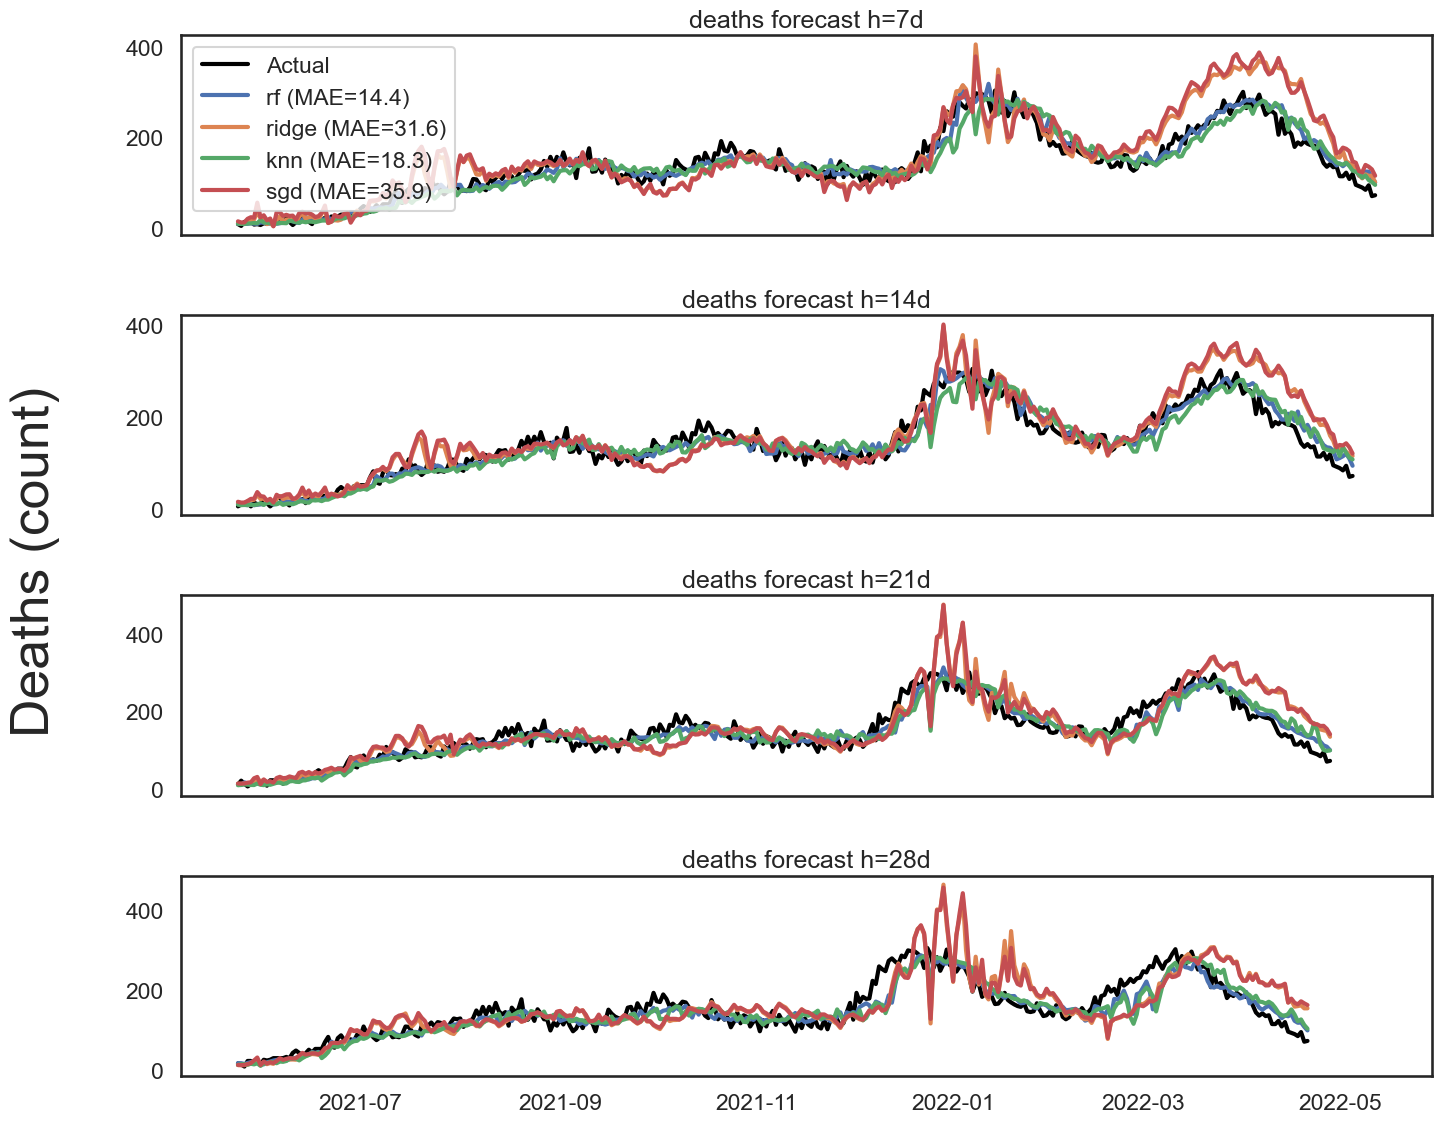

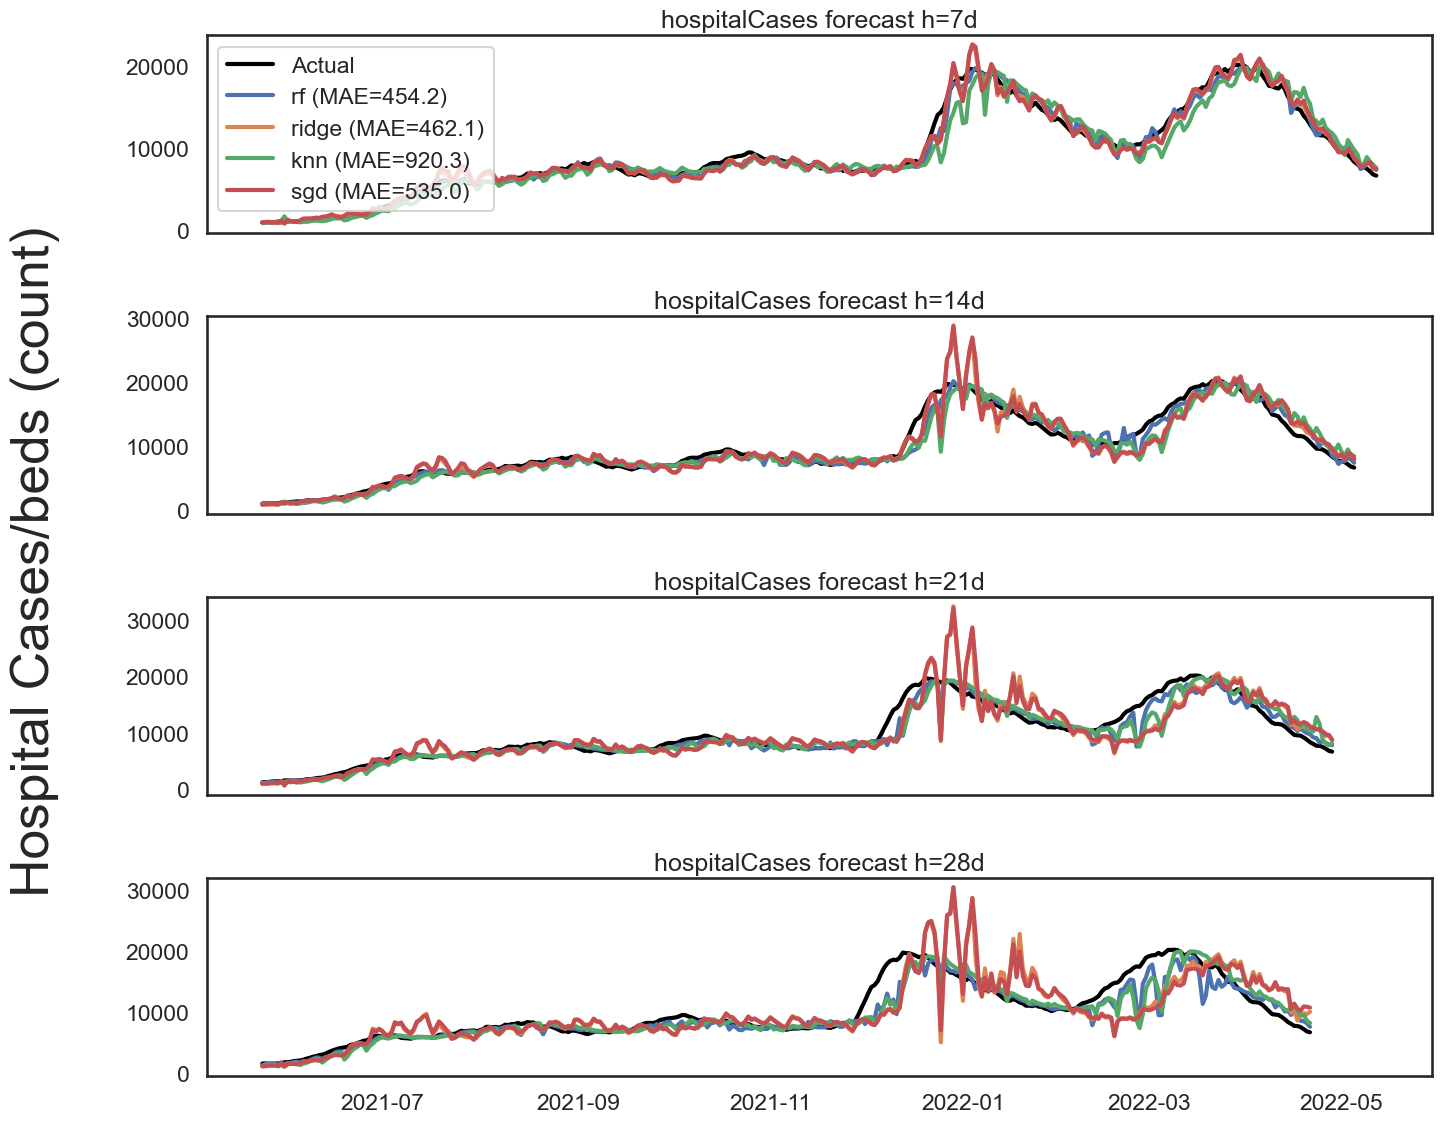

In [96]:
def best_by_horizon(df):
    df2 = df.sort_values(["horizon", "MAE"]).groupby("horizon", as_index=False).first()
    return df2[["horizon", "model", "MAE", "RMSE", "MAPE_pct", "R2", "n_train", "n_test"]]

best_deaths = best_by_horizon(metrics_deaths_all)
best_hosp   = best_by_horizon(metrics_hosp_all)

print("Best models per horizon — deaths")
display(best_deaths)

print("Best models per horizon — hospitalCases")
display(best_hosp)

import matplotlib.pyplot as plt

def plot(all_results, title_prefix, horizons):
    plot_from_results(all_results, title_prefix, horizons)


plot(results_deaths, "deaths", HORIZONS)
plot(results_hosp, "hospitalCases", HORIZONS)

##### Conclusion

So we made a supervised time lag forecast for UK daily deaths by covid and hospital bed occupancy using merged NHS and Google mobility data.

Across the full period walk forward with an expanding window our evaluation shows short horizon performance (1-2 weeks) is best with KNN for deaths and Ridge for beds. Beyond this 2 week window RF is the most robust as other models lose accuracy quickly during downward shifts. 

Absolut error grows with horizon and variance fit degrades quickly after 2 weeks, especially so for deaths. Probably due to regime changes (real life changes how other factors make the data less indicative of deaths) and limited sample size.

Mobility + NHS data lags provide useful short term prediction but not so much on long horizons. Beyond that simple monitoring of the situation might just be better. 

#### ASIDE
- In feedback (got feedback twice, once in class from another TA and online) was told to talk more about plots/tables after showing them so tried to keep that in mind.
- Added docstrings to functions() as was also asked, tried to not repeat code and use functions instead. Try different methods and see what worked best.